In [ ]:
# # Connecting Google Colab with Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing Required Packages
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# The Function is Used to Detect Crack for CrackImage.png file

### Parameter Values values:
    *  bilateralFilter --> 9,75,75
    *  Canny Edge Detection --> 50, 150
    *  Mprphological Kernel size --> (3,3)

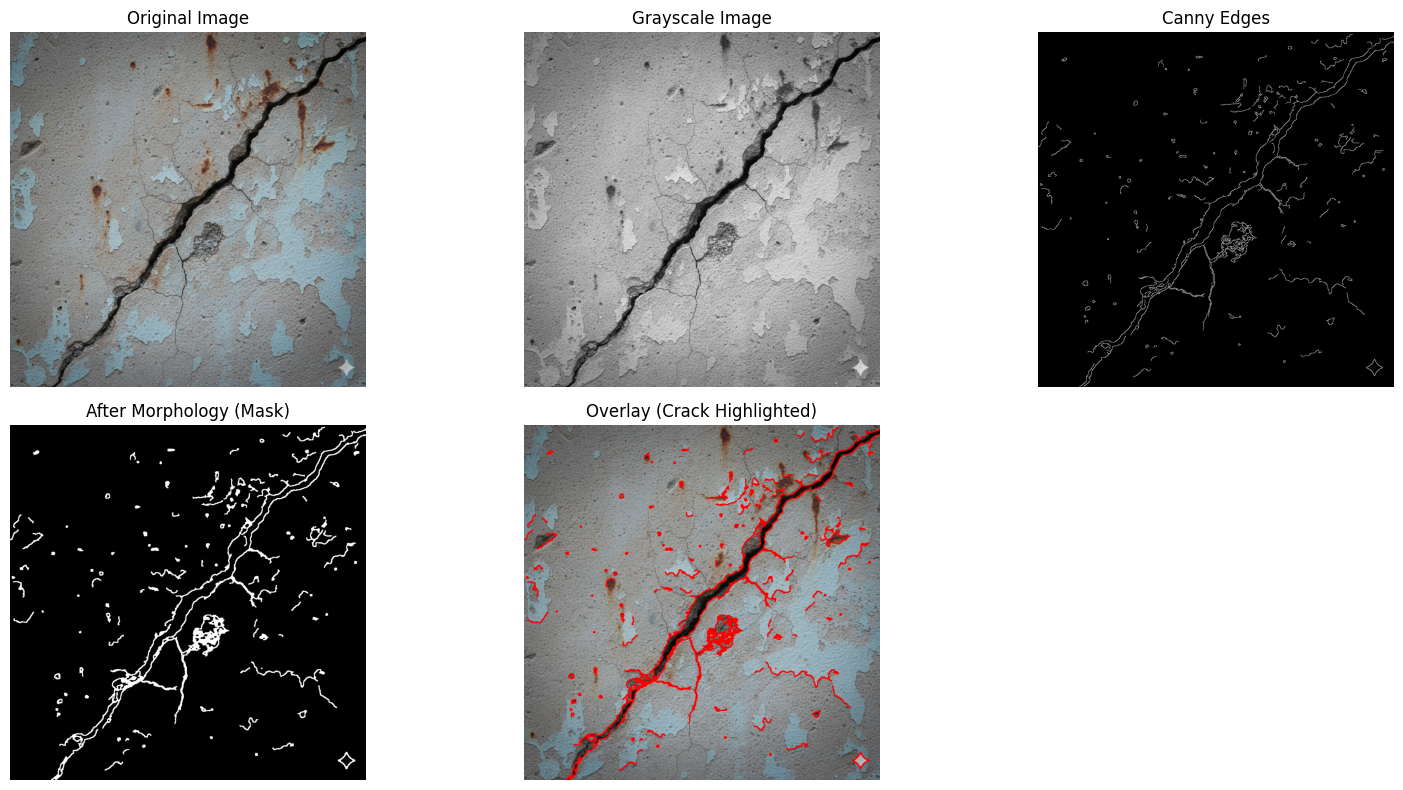

Crack area (in pixels): 48221
The Crack Severity is High


In [7]:
# Creating a function to get the crack segmentation
def get_crack_segmentation(image_path):

  # Step 1: Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or path is incorrect")

    # Step 2: Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 3: Apply smoothing (bilateral filter preserves edges)
    blur = cv2.bilateralFilter(gray, 9, 75, 75)

    # Step 4: Detect edges (potential cracks)
    edges = cv2.Canny(blur, 50, 150)

    # Step 5: Morphological operations to close gaps in cracks
    kernel = np.ones((3,3), np.uint8)
    crack_mask = cv2.dilate(edges, kernel, iterations=1)
    crack_mask = cv2.morphologyEx(crack_mask, cv2.MORPH_CLOSE, kernel)

    # Step 6: Pixel-wise crack area (number of white pixels in mask)
    crack_area_px = np.sum(crack_mask > 0)

    # Step 7: Create overlay for visualization
    overlay = img.copy()
    overlay[crack_mask > 0] = [0, 0, 255]  # Highlight cracks in red

    # Step 8: Show results
    plt.figure(figsize=(16,8))

    plt.subplot(2,3,1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(2,3,2)
    plt.title("Grayscale Image")
    plt.imshow(gray, cmap="gray")
    plt.axis("off")

    plt.subplot(2,3,3)
    plt.title("Canny Edges")
    plt.imshow(edges, cmap="gray")
    plt.axis("off")

    plt.subplot(2,3,4)
    plt.title("After Morphology (Mask)")
    plt.imshow(crack_mask, cmap="gray")
    plt.axis("off")

    plt.subplot(2,3,5)
    plt.title("Overlay (Crack Highlighted)")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print("Crack area (in pixels):", crack_area_px)

    # Applying a Threshold value to Measure it a Crack is High or Low Based on Measurement
    if crack_area_px >= 40000:
      print("The Crack Severity is High")
    elif crack_area_px >= 20000 and crack_area_px < 40000:
      print("The Crack Severity is Medium")
    else:
      print("The Crack Severity is Low")

    return crack_area_px


# Example usage
if __name__ == "__main__":
  image_path = "/content/CrackImage.png"
  area = get_crack_segmentation(image_path)

# The Function is used to Detect Damp on the Image DampImage.png

### Different Parameter Values:
    * bilateralFilter --> 9, 75, 75
    * Canny Edge Detection --> 50, 150
    * hsv lower stain --> [15,80,80]
    * hsv upper stain --> [60,255,255]
    * hsv lower dark damp --> [0,0,0]
    * hsv upper dark damp --> [180,100,100]
    * Morphological kernel size --> (5,5)


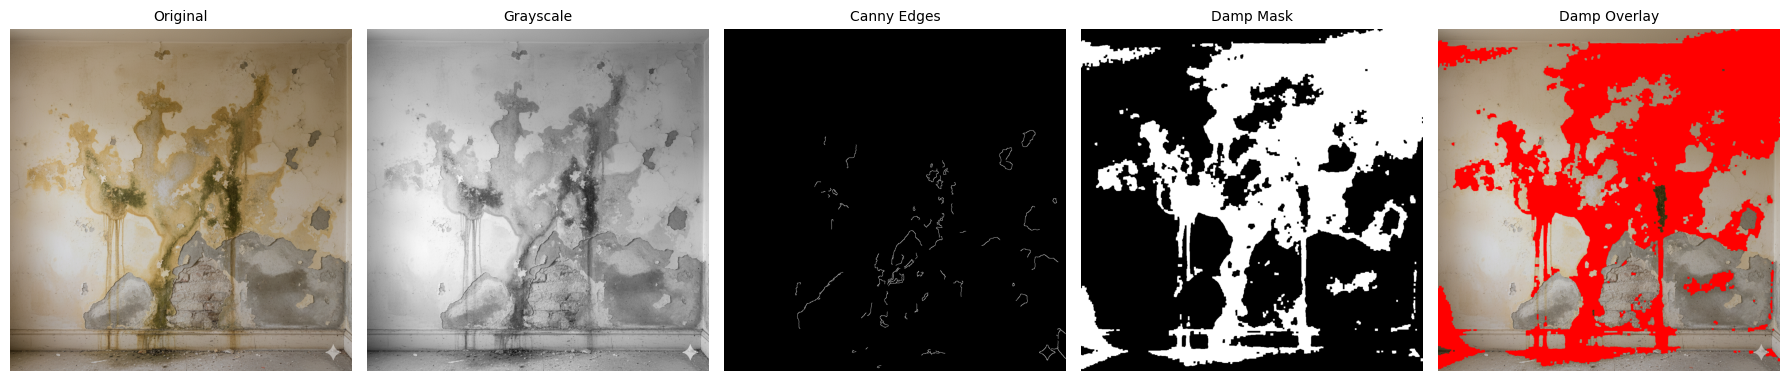

Crack Ratio: 0.004727363586425781
Damp Ratio: 0.3965597152709961
Damp Area (pixels): 415823
The Damp Severity is High


In [12]:
# Define function to get the Damp Segmentation
def get_damp_segmentation(image_path):

    # Step 1: Load image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or path is incorrect")

    # Step 2: Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 3: Apply bilateral filter (preserve edges while smoothing)
    blur = cv2.bilateralFilter(gray, 9, 75, 75)

    # Step 4: Edge detection for cracks
    edges = cv2.Canny(blur, 50, 150)
    crack_ratio = np.sum(edges > 0) / edges.size

    # Step 5: HSV conversion for damp region detection
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # # Damp often appears as dark/greenish/yellowish stains
    # lower_damp = np.array([15, 40, 40])   # adjust range for damp yellow/green
    # upper_damp = np.array([40, 255, 255])

    # Mask 1: Yellow/Green Stains (Fungal/Mold Growth) # H: 15-40 for Yellow/Green # S: min 40 # V: min 40
    lower_stain = np.array([15, 80, 80]) # [15, 80, 80]
    upper_stain = np.array([60, 255, 255]) # [0, 255, 255]
    mask_stain = cv2.inRange(hsv, lower_stain, upper_stain)

    # Mask 2: Dark/Gray Damp Areas (Low Saturation/Value) # H: Any hue (0-180) # S: Low Saturation (0-80) to catch gray # V: Low Value (0-150) to catch dark areas
    lower_dark_damp = np.array([0, 0, 0])
    upper_dark_damp = np.array([180, 100, 100]) # [180, 80, 150] # best: [180, 100, 100]
    mask_dark = cv2.inRange(hsv, lower_dark_damp, upper_dark_damp)

    # mask_damp = cv2.inRange(hsv, lower_damp, upper_damp)
    mask_damp = cv2.bitwise_or(mask_stain, mask_dark)

    # Step 6: Morphological cleanup of damp mask
    kernel = np.ones((5,5), np.uint8)
    mask_damp = cv2.morphologyEx(mask_damp, cv2.MORPH_CLOSE, kernel)
    mask_damp = cv2.morphologyEx(mask_damp, cv2.MORPH_OPEN, kernel)

    damp_area_px = np.sum(mask_damp > 0)
    damp_ratio = damp_area_px / mask_damp.size

    # Step 7: Overlay damp mask in red
    overlay = img.copy()
    overlay[mask_damp > 0] = [0, 0, 255]  # damp in red

    # Step 8: Display results in one row
    images = [
        (cv2.cvtColor(img, cv2.COLOR_BGR2RGB), "Original"),
        (gray, "Grayscale"),
        (edges, "Canny Edges"),
        (mask_damp, "Damp Mask"),
        (cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB), "Damp Overlay")
    ]

    plt.figure(figsize=(18,4))
    for i, (im, title) in enumerate(images):
        plt.subplot(1, len(images), i+1)
        if len(im.shape) == 2:
            plt.imshow(im, cmap="gray")
        else:
            plt.imshow(im)
        plt.title(title, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    print("Crack Ratio:", crack_ratio)
    print("Damp Ratio:", damp_ratio)
    print("Damp Area (pixels):", damp_area_px)

    # Thresholding to Get the Severity of the Damp by its area
    if damp_area_px >= 350000:
      print("The Damp Severity is High")
    elif damp_area_px >= 200000 and damp_area_px < 350000:
      print("The Damp Severity is Medium")
    else:
      print("The Damp Severity is Low")

    return damp_area_px

# Example Usage
if __name__ == "__main__":
  image_path = "/content/DampImage.png"
  area = get_damp_segmentation(image_path)

# The Function is used to detect Damp on the Image DampImage_2.png

### Different Parameter Values for damp:
    * bilateralFilter --> 9, 75, 75
    * Canny Edge Detection --> 50, 150
    * hsv lower stain --> [5,20,150]
    * hsv upper stain --> [45,100,255]
    * hsv lower dark damp --> [0,0,70]
    * hsv upper dark damp --> [180,50,100]
    * Morphological kernel size --> (5,5)

### Different Parameter Values for Paint Peeling:
    * bilateralFilter --> 9, 75, 75
    * Canny Edge Detection --> 50, 150
    * hsv lower stain --> [15,80,80]
    * hsv upper stain --> [60,255,255]
    * hsv lower dark damp --> [0,0,0]
    * hsv upper dark damp --> [180,100,100]
    * Morphological kernel size --> (5,5)

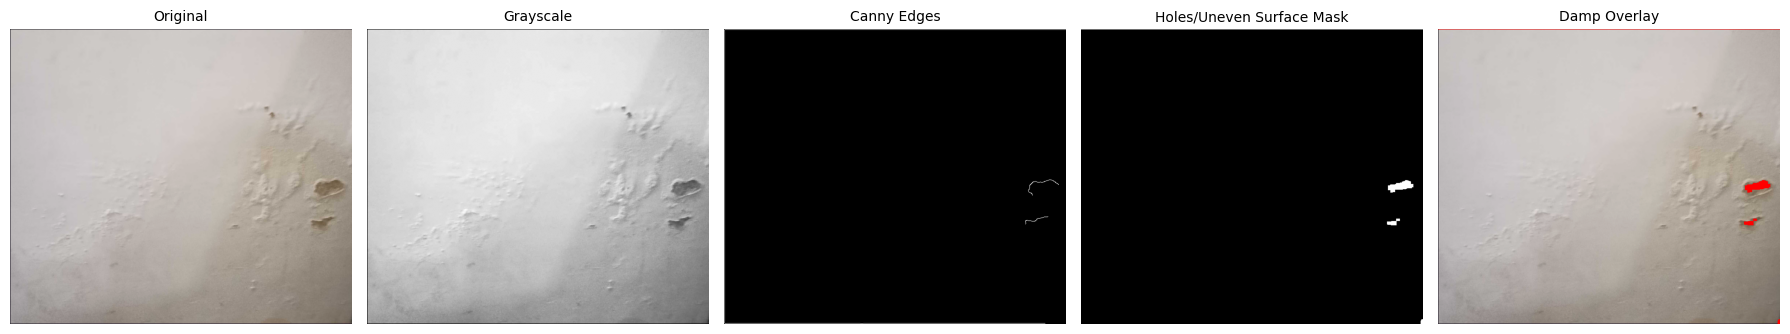

Crack Ratio: 0.0049077372796199874
Damp Ratio: 0.007198319174202978
Damp Area (pixels): 3152


In [ ]:

def hole_segmentation(image_path):
    # Step 1: Load image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or path is incorrect")

    # Step 2: Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 3: Apply bilateral filter (preserve edges while smoothing)
    blur = cv2.bilateralFilter(gray, 9, 75, 75)

    # Step 4: Edge detection for cracks
    edges = cv2.Canny(blur, 50, 150)
    crack_ratio = np.sum(edges > 0) / edges.size

    # Step 5: HSV conversion for damp region detection
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # # Damp often appears as dark/greenish/yellowish stains
    # lower_damp = np.array([15, 40, 40])   # adjust range for damp yellow/green
    # upper_damp = np.array([40, 255, 255])

    # Mask 1: Yellow/Green Stains (Fungal/Mold Growth) # H: 15-40 for Yellow/Green # S: min 40 # V: min 40
    lower_stain = np.array([15, 80, 80]) # [15, 80, 80]
    upper_stain = np.array([60, 255, 255]) # [60, 255, 255]
    mask_stain = cv2.inRange(hsv, lower_stain, upper_stain)

    # Mask 2: Dark/Gray Damp Areas (Low Saturation/Value) # H: Any hue (0-180) # S: Low Saturation (0-80) to catch gray # V: Low Value (0-150) to catch dark areas
    lower_dark_damp = np.array([0, 0, 0]) # [0,0,0]
    upper_dark_damp = np.array([180, 100, 100]) # [180, 100, 100] # best: [180, 100, 100]
    mask_dark = cv2.inRange(hsv, lower_dark_damp, upper_dark_damp)

    # mask_damp = cv2.inRange(hsv, lower_damp, upper_damp)
    mask_damp = cv2.bitwise_or(mask_stain, mask_dark)

    # Step 6: Morphological cleanup of damp mask
    kernel = np.ones((5,5), np.uint8)
    mask_damp = cv2.morphologyEx(mask_damp, cv2.MORPH_CLOSE, kernel)
    mask_damp = cv2.morphologyEx(mask_damp, cv2.MORPH_OPEN, kernel)

    damp_ratio = np.sum(mask_damp > 0) / mask_damp.size

    # Step 7: Overlay damp mask in red
    overlay = img.copy()
    overlay[mask_damp > 0] = [0, 0, 255]  # damp in red

    # Step 8: Display results in one row
    images = [
        (cv2.cvtColor(img, cv2.COLOR_BGR2RGB), "Original"),
        (gray, "Grayscale"),
        (edges, "Canny Edges"),
        (mask_damp, "Holes/Uneven Surface Mask"),
        (cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB), "Damp Overlay")
    ]

    plt.figure(figsize=(18,4))
    for i, (im, title) in enumerate(images):
        plt.subplot(1, len(images), i+1)
        if len(im.shape) == 2:
            plt.imshow(im, cmap="gray")
        else:
            plt.imshow(im)
        plt.title(title, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    print("Crack Ratio:", crack_ratio)
    print("Damp Ratio:", damp_ratio)
    print("Damp Area (pixels):", np.sum(mask_damp > 0))

    return mask_damp, damp_ratio


mask, ratio = hole_segmentation(image3_path)

# This function is used on the Image PaintPeeling.png


### The Parameter values are:
    * hsv lower beige --> [10, 20,100]
    * hsv upper beige --> [35,120,255]
    * hsv lower green --> [45,60,60]
    * hsv upper green --> [80,200,150]
    * Morphological kernel sizes --> (3,3) and (7,7)

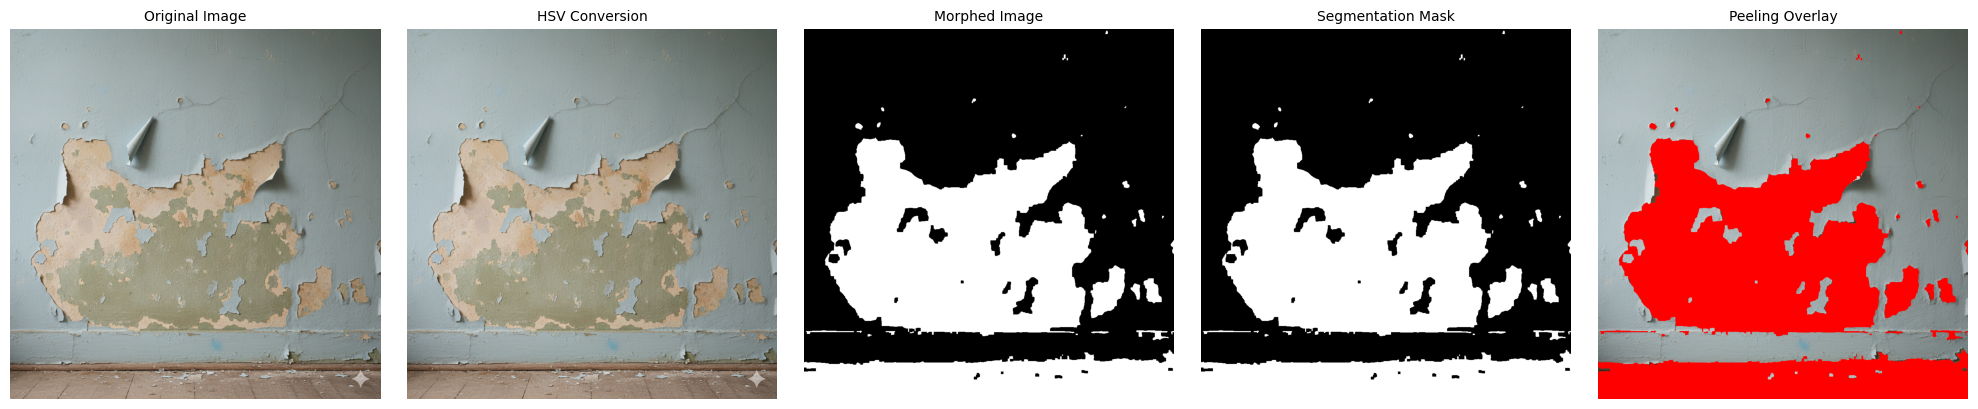

Total Peeling Area (in pixels): 399543


In [ ]:
# Define Function to Detect the Paint Peeling
def peeling_segmentation(image_path):
    # Step 1: Load image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at path: {image_path}")

    # Step 2: Convert to HSV for robust color segmentation
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # NOTE: To display the HSV image visually, we usually convert it back to BGR
    hsv_display = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # --- Step 3: Define HSV Masks for Exposed Layers ---

    # Mask 1: Beige/Tan Exposed Plaster
    lower_beige = np.array([10, 20, 100])
    upper_beige = np.array([35, 120, 255])
    mask_beige = cv2.inRange(hsv, lower_beige, upper_beige)

    # Mask 2: Inner Dark Green/Grayish Layer
    lower_green = np.array([45, 60, 60]) # [45, 50, 50]
    upper_green = np.array([80, 200, 150]) # [80, 200, 200]
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # Combine the two masks using bitwise OR
    combined_mask = cv2.bitwise_or(mask_beige, mask_green)

    # --- Step 4: Morphological Cleanup ---
    kernel = np.ones((7, 7), np.uint8) # Closing kernel
    morphed_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

    kernel_small = np.ones((3, 3), np.uint8) # Opening kernel
    morphed_mask = cv2.morphologyEx(morphed_mask, cv2.MORPH_OPEN, kernel_small)

    # Step 5: Final Segmentation Mask
    segmentation_mask = morphed_mask.copy()

    # Step 6: Calculate Area and Create Overlay
    peel_area_pixels = np.sum(segmentation_mask > 0)

    # Create the overlay
    overlay = img.copy()
    red_color_bgr = [0, 0, 255] # BGR for RED
    overlay[segmentation_mask > 0] = red_color_bgr

    # Step 7: Display results in a single row

    images = [
        (cv2.cvtColor(img, cv2.COLOR_BGR2RGB), "Original Image"),
        (cv2.cvtColor(hsv_display, cv2.COLOR_BGR2RGB), "HSV Conversion"),
        (morphed_mask, "Morphed Image"), # Result after morphology
        (segmentation_mask, "Segmentation Mask"), # Binary mask
        (cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB), "Peeling Overlay")
    ]

    plt.figure(figsize=(20, 4)) # Adjusted figsize for 5 images
    num_images = len(images)

    for i, (im, title) in enumerate(images):
        plt.subplot(1, num_images, i + 1)
        plt.title(title, fontsize=10)

        if len(im.shape) == 2:
            plt.imshow(im, cmap="gray")
        else:
            plt.imshow(im)

        plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Total Peeling Area (in pixels): {peel_area_pixels}")

    return segmentation_mask, peel_area_pixels

# Run the segmentation
image4_path = "/content/drive/MyDrive/WEBBIES_NOTEBOOKS/BERGER/Berger Ext QC and QA Price Suggestor/PaintPeelingImage.png"
mask, area = peeling_segmentation(image4_path) # Uncomment to run

# The Function to Analyse the the GreenWallImage.png file


### Parameter Values to set:
    * hsv lower v --> 30
    * hsv upper v --> 230
    * Canny Edge --> (50,150)
    * Morphological Kernel size --> (5,5)
    * Max saturation for testing --> 200
    * Highest Saturation --> 255


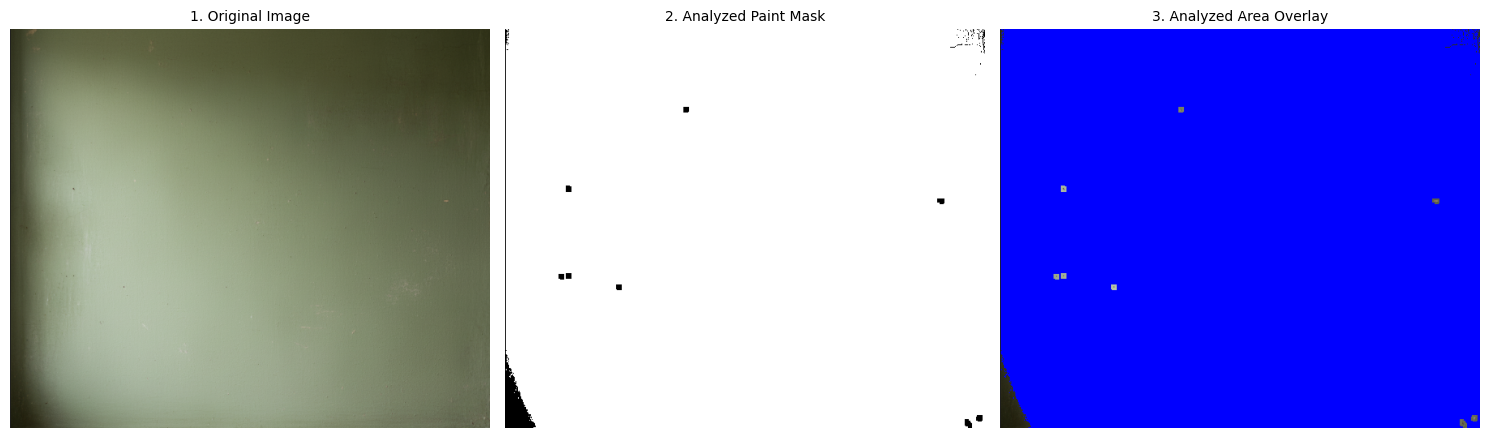

Mean Paint Saturation (S-Channel): 60.97 (Max 255)
Assumed Max Saturation for Score: 200
Estimated Fading Score (0=New, 100=Max Fade): 69.51
Analyzed Area (in pixels): 288628


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# The analyze_paint_fading function
def analyze_paint_fading(image_path):
    """
    Analyzes an image to determine the degree of paint fading based on color saturation,
    and calculates the area analyzed.

    Args:
        image_path (str): The path to the image file.

    Returns:
        tuple: (mean_saturation, fading_score, analyzed_area_pixels)
               - mean_saturation (float): Average saturation of the analyzed paint area.
               - fading_score (float): Score from 0 (New/Vibrant) to 100 (Severely Faded).
               - analyzed_area_pixels (int): The total number of pixels used for the analysis.
    """
    # Step 1: Load image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at path: {image_path}")

    # Step 2: Convert to HSV for Saturation analysis
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Extract the Saturation channel (S-channel)
    saturation_channel = hsv[:, :, 1]
    value_channel = hsv[:, :, 2]

    # --- Step 3: Identify a Representative Area of the Paint (Masking) ---
    # Create a mask to isolate the wall surface (V between 50 and 230)
    lower_V = 50
    upper_V = 230
    wall_mask = cv2.inRange(value_channel, lower_V, upper_V)

    # Remove areas of complex texture (edges/cracks)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    kernel = np.ones((5,5), np.uint8)
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)

    # Final robust mask for the smooth, central wall area:
    texture_mask = cv2.bitwise_and(wall_mask, wall_mask, mask = ~edges_dilated)

    # --- Step 4: Calculate Mean Saturation (The Fading Metric) ---
    # Use the robust mask to calculate the mean saturation only on the clean paint area.
    valid_pixels = saturation_channel[texture_mask > 0]

    if valid_pixels.size == 0:
        print("Warning: Could not isolate a clean paint area for analysis. Returning 0 saturation and 100 fading score.")
        mean_saturation = 0
    else:
        # Saturation values range from 0 (pure gray/white) to 255 (pure color)
        mean_saturation = np.mean(valid_pixels)

    # --- Step 4.5: Calculate Analyzed Area in Pixels ---
    # Count the number of white pixels in the texture_mask
    analyzed_area_pixels = np.sum(texture_mask > 0)

    # --- Step 5: Calculate Fading Score ---
    max_saturation = 200 # Assumed Max Saturation (as per your code)
    if max_saturation <= 0:
        fading_score = 100.0
    else:
        fading_score = 100.0 * (1 - (mean_saturation / max_saturation))

    # Clamp score between 0 and 100
    fading_score = max(0, min(100, fading_score))

    # --- Step 6: Display Results ---

    # Create an overlay for the analyzed area
    overlay = img.copy()
    overlay[texture_mask > 0] = [255, 0, 0] # Highlight analyzed area in blue

    images = [
        (cv2.cvtColor(img, cv2.COLOR_BGR2RGB), "1. Original Image"),
        (texture_mask, "2. Analyzed Paint Mask"),
        (cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB), "3. Analyzed Area Overlay")
    ]

    plt.figure(figsize=(15, 5))
    for i, (im, title) in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.title(title, fontsize=10)

        if len(im.shape) == 2:
            plt.imshow(im, cmap="gray")
        else:
            plt.imshow(im)

        plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Mean Paint Saturation (S-Channel): {mean_saturation:.2f} (Max 255)")
    print(f"Assumed Max Saturation for Score: {max_saturation}")
    print(f"Estimated Fading Score (0=New, 100=Max Fade): {fading_score:.2f}")
    print(f"Analyzed Area (in pixels): {analyzed_area_pixels}") # New Output

    return mean_saturation, fading_score, analyzed_area_pixels

# Execute the analysis
image5_path = "/content/drive/MyDrive/WEBBIES_NOTEBOOKS/BERGER/Berger Ext QC and QA Price Suggestor/GreenWallImage.png"
mean_sat, fade_score, analyzed_area = analyze_paint_fading(image5_path) # Uncomment to run